In [ ]:
!pip install python-chess

In [1]:
import random
import chess
from IPython.display import SVG, display
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
def play_random(fen):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)
    
    # And then randomly pick a legal move:
    move = random.choice(list(board.legal_moves))

    # Now we turn our move into a string, return it and call it a day!
    return str(move)

In [3]:
def isDiff_from_last(cur, las):
    cur =str(cur)
    las =str(las)
    # print("cur: ", cur[0:2], "las: ", las[2:4])
    # print("result: ", cur[0:2] != las[2:4])
    if cur[0:2] == las[2:4] and cur[2:4] == las[0:2]:
        return False
    return True

In [4]:
svgarr = []
# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()
    l_user_move = None
    l_ai_move = None
    turn = 0
    while board.outcome() is None:
        # We print out the board as an SVG
        svgarr.append((SVG(board._repr_svg_())))
        

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            # user_move = input('Your move: ')
            # if user_move == 'quit':
            #     break
            # # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            # while user_move not in [str(move) for move in board.legal_moves]:
            #     print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
            #     user_move = input('Your move: ')
            user_move = play_random(board.fen())
            # while not isDiff_from_last(user_move, l_user_move):
            #     #print(f'cur: {user_move}, las: {l_user_move}')
            #     user_move = play_random(board.fen())
            print(f'{turn}.user move: {user_move}')
            board.push_san(user_move)
            l_user_move = user_move

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            # while not isDiff_from_last(ai_move, l_ai_move):
            #     #print(f'cur: {ai_move}, las: {l_ai_move}')
            #     ai_move = ai_function(board.fen())
            print(f'{turn}.AI move: {ai_move}')
            board.push_san(ai_move)
            l_ai_move = ai_move
        turn+=1
        #print(turn)
    print(board.outcome())

In [5]:
# Now lets use that function to encode our entire board

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    material_dict = {
        'p': -1,
        'b': -3.5,
        'n': -3,
        'r': -5,
        'q': -9,
        'k': -400,
        'K': 400,
        '.': 0,
        'P': 10,
        'B': 3.5,
        'N': 3,
        'R': 5,
        'Q': 9,
    }
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            # print(piece)
            row_list.append(material_dict.get(piece))
        board_list.append(row_list)
    return np.array(board_list)

# Let's test on the starting board
encode_board(chess.Board())

array([[-5. , -3. , -3.5, -9. , -4. , -3.5, -3. , -5. ],
       [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ],
       [ 5. ,  3. ,  3.5,  9. ,  4. ,  3.5,  3. ,  5. ]])

In [6]:
train_df = pd.read_csv('data/train.csv', index_col='id')

train_df = train_df[:55000]

val_df = train_df[-1000:]
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [7]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [8]:
print(X_train.shape)
print(y_train.shape)

(55000, 8, 8)
(55000,)


In [8]:

def create_model():
    model = Sequential()
    model.add(Flatten(input_shape=(8, 8)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

model = create_model()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,225 (516.50 KB)

 Trainable params: 132,225 (516.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',loss='mean_squared_error')
# To test things out, let's train for 20 epochs and see how our model is doing
history = model.fit(X_train,y_train,epochs=50,validation_data=(X_val, y_val))

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 145053.6406 - val_loss: 94161.8125
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 99439.4531 - val_loss: 72732.3828
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 81226.5781 - val_loss: 67453.2891
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 76069.6797 - val_loss: 58759.8242
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 67025.1719 - val_loss: 53536.8867
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 60172.7422 - val_loss: 47625.1484
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 58777.5000 - val_loss: 43746.1367
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 53656.1133 - val_loss: 40606.2422
Epoch 9/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 47324.6602 - val_loss: 38644.6875
Epoch 10/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 47426.7734 - val_loss: 41135.8555
Epoch 11/50
1719/1719 ━━━━━━━━━━━━━━━━

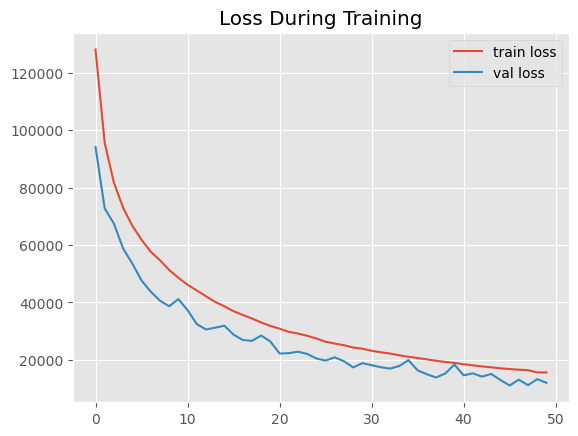

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [10]:
# Lets plot the history of our training session to see how things progressed over time
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

model.predict(X_val[:10])
model.save('model.h5')

In [15]:
def play_nn(fen, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)
    loadmodel = load_model('model.h5')  
    # And then evaluate all legal moves
    best_move = ''
    worst_move = ''
    minScore = float('inf')
    maxScore = float('-inf')

    moves = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board)).astype(np.int32)
        
        # This is where our model gets to shine! It tells us how good the resultant score board is for black:
        score = loadmodel.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        if score > maxScore:
            best_move = move
            maxScore = score
        elif score < minScore:
            worst_move = move
            minScore = score
        # moves.append((score, move))
        # if show_move_evaluations:
        #     print(f'{move}: {score}')
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    
    # if(player=='b'):
    #     return str(worst_move)
    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [16]:
### Now that we have a policy, we can play against it!
svgarr = []
play_game(play_nn)


0.user move: g2g4


1.AI move: d7d5
2.user move: a2a3


3.AI move: c7c6
4.user move: f1g2


5.AI move: e7e5
6.user move: e2e3


7.AI move: f8b4
8.user move: f2f4


9.AI move: g8f6
10.user move: h2h4


11.AI move: f6g4
12.user move: h1h2


13.AI move: g4e3
14.user move: d1f3


15.AI move: e3g2
16.user move: f3g2


17.AI move: b4d2
18.user move: c1d2


19.AI move: d8f6
20.user move: f4f5


21.AI move: d5d4
22.user move: g2g4


23.AI move: a7a5
24.user move: e1f1


25.AI move: c8e6
26.user move: d2a5


27.AI move: a8a5
28.user move: h2h1


29.AI move: e6d5
30.user move: c2c3


31.AI move: d4c3
32.user move: g4d4


33.AI move: a5c5
34.user move: h1h3


35.AI move: e8d7
36.user move: h3g3


37.AI move: b8a6
38.user move: d4d2


39.AI move: c3d2
40.user move: f1e2


41.AI move: d2d1q
42.user move: e2e3


43.AI move: c5c3
44.user move: e3f2


45.AI move: d5b3
46.user move: a3a4


47.AI move: d1d2
48.user move: g1e2


49.AI move: b7b6
50.user move: g3g2


51.AI move: c3h3
52.user move: a1a3


53.AI move: b3d1
54.user move: a4a5


55.AI move: d2b4
56.user move: a3b3


57.AI move: h3b3
58.user move: g2g1


59.AI move: b3d3
60.user move: g1f1


61.AI move: d3d2
62.user move: f1h1


63.AI move: f6e7
64.user move: f2f3


65.AI move: d1e2
66.user move: f3e3


67.AI move: c6c5
68.user move: h1d1


69.AI move: e2d1
70.user move: b1d2


71.AI move: b4d2
72.user move: e3e4


73.AI move: h8a8
74.user move: h4h5


75.AI move: d1h5
76.user move: f5f6


77.AI move: a8b8
78.user move: b2b3


79.AI move: a6b4
80.user move: a5b6


81.AI move: b8b6
82.user move: f6e7


83.AI move: d2d1
84.user move: e4e3


85.AI move: d7e7
86.user move: e3f2


87.AI move: b6a6
88.user move: f2g3


89.AI move: e5e4
90.user move: g3f2


91.AI move: f7f5
92.user move: f2g2


93.AI move: e7d7
94.user move: g2g3


95.AI move: d7c8
96.user move: g3f2


97.AI move: h7h6
98.user move: f2g3


99.AI move: g7g5
100.user move: g3f2


101.AI move: h5g6
102.user move: f2e3


103.AI move: g6f7
104.user move: e3f2


105.AI move: f7g8
106.user move: f2g2


107.AI move: f5f4
108.user move: g2h3


109.AI move: f4f3
110.user move: h3g3


111.AI move: b4c6
112.user move: g3h2


113.AI move: c6b8
114.user move: h2g3


115.AI move: b8c6
116.user move: g3g4


117.AI move: c5c4
118.user move: g4f5


119.AI move: c4b3
120.user move: f5g6


121.AI move: c8d7
122.user move: g6h6


123.AI move: f3f2
124.user move: h6g5


125.AI move: f2f1q
126.user move: g5h6


127.AI move: f1h3
128.user move: h6g5


129.AI move: g8f7
130.user move: g5f6


131.AI move: c6e7
132.user move: f6g5


133.AI move: f7c4
134.user move: g5f4


135.AI move: c4d3
136.user move: f4g5


137.AI move: b3b2
138.user move: g5f4


139.AI move: b2b1q
140.user move: f4g5


141.AI move: b1b7
142.user move: g5f4


143.AI move: b7c8
144.user move: f4g5


145.AI move: c8b7
146.user move: g5f4


147.AI move: b7c8
148.user move: f4e5


149.AI move: e7g8
150.user move: e5d4


151.AI move: c8f8
152.user move: d4e5


153.AI move: f8f6
154.user move: e5d5


155.AI move: f6f8
156.user move: d5d4


157.AI move: f8f6
158.user move: d4d5


159.AI move: f6f8
160.user move: d5d4


161.AI move: f8f6
162.user move: d4c5


163.AI move: e4e3
164.user move: c5b4


165.AI move: e3e2
166.user move: b4c5


167.AI move: e2e1q
168.user move: c5d5


169.AI move: e1g3
170.user move: d5c5


171.AI move: g3e1
172.user move: c5d5


173.AI move: e1g3
174.user move: d5c5


175.AI move: g3e1
176.user move: c5d5


177.AI move: e1g3
178.user move: d5c5


179.AI move: g3e1
180.user move: c5d5


181.AI move: e1g3
182.user move: d5c5
183.AI move: g3e1
Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)


In [17]:
import os
from IPython.display import SVG
import cairosvg
#os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1"
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip
from PIL import Image

In [22]:
# Define paths
svg_folder = "svg_folder"
png_folder = "png_folder"
output_video = "output.mp4"

# Ensure the folders exist
os.makedirs(svg_folder, exist_ok=True)
os.makedirs(png_folder, exist_ok=True)

# Step 1: Save SVG data to files
def save_svg(svg_obj, path):
    with open(path, 'w') as file:
        file.write(svg_obj.data)
print(len(svgarr))
for i, svg_obj in enumerate(svgarr):
    print("index: ",i)
    svg_path = os.path.join(svg_folder, f'image{i:04d}.svg')
    save_svg(svg_obj, svg_path)

# Step 2: Convert SVG to PNG with uniform size
def convert_svg_to_png(svg_path, png_path, width, height):
    cairosvg.svg2png(url=svg_path, write_to=png_path, output_width=width, output_height=height)

# Determine desired width and height for the PNGs
desired_width = 1024  # Change this to your desired width
desired_height = 1024  # Change this to your desired height

svg_files = sorted([f for f in os.listdir(svg_folder) if f.endswith('.svg')])

for svg_file in svg_files:
    svg_path = os.path.join(svg_folder, svg_file)
    png_path = os.path.join(png_folder, f'{os.path.splitext(svg_file)[0]}.png')
    convert_svg_to_png(svg_path, png_path, desired_width, desired_height)

# Step 3: Create a video from PNG files
png_files = sorted([os.path.join(png_folder, f) for f in os.listdir(png_folder) if f.endswith('.png')])

clip = ImageSequenceClip(png_files, fps=7)
clip.write_videofile(output_video, codec='libx264')

print(f"Video created: {output_video}")


184
index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index:  90
index

Moviepy - Done !
Moviepy - video ready output.mp4
Video created: output.mp4
